# Regression and Statistical Modelling
To carry out statistical tests in Python, we will be using an external module called [SciPy](https://www.scipy.org/), and to perform statistical modelling we will use the `ols` function from the external module [statsmodels](https://www.statsmodels.org/stable/index.html). To install these modules, launch the "Comand Prompt" program and run the following commands:

`pip install -U statsmodels`

`pip install -U scipy`



We will alias SciPy as `sp`, import the `ols` function from the `statsmodels.formula.api` module, and import numpy, pandas and plotnine using their usual aliases.

**Notebook road map:**
1. **Setup:** Import libraries, load CSV, and perform initial inspections.  
2. **Quick EDA:** Peek at key variables, visualize distributions, and compute a correlation matrix.  
3. **Hypothesis Tests:** Run a two-sample t-test, one-way ANOVA, and a chi-square test to compare groups and test associations.  
4. **Transformations:** Apply log transforms to skewed variables and encode categorical predictors for regression.  
5. **OLS Regression:** Fit both simple and multiple OLS models, interpret coefficients and R², and check residual diagnostics.

Let's begin by importing the necessary libraries and loading our raw data files.

In [4]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm


### Data
To demonstrate the statistical tests in Python, we’ll use our cleaned HES datasets. Some of the pandas and statsmodels routines we plan to apply don’t handle missing values, so we’ll first need to drop any rows in each sheet that contain NaN. Then, as we saw previously, we can call the describe() method to quickly generate summary statistics for each dataset:

In [6]:
# File
hes_df = pd.read_csv('../data/merged_HES.csv')


#### First, we need to make sure our data is ready for analysis...

In [8]:
# 1.1 Read metadata from Excel
# codebook = pd.read_excel('../data/HES 2023 Annex A_forNUS.xlsx')

In [9]:
# Confirm shape and a snapshot
print(hes_df.shape)
display(hes_df.head())


(30016, 581)


,RELT_TO_HD,AGE,MARITAL_ST,ACTIVITY_ST,HQA,LVL_OF_EDN,SSOC_1D,ID_TYPE,TENANCY,HSE_TYPE,...,_1429,_143,_14300101_05,_14300106_09,_143_OTH,_144,_14A,_71,_711,_713
0,1,7,4.0,5.0,6,9,9,1,1,6,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
1,2,5,2.0,1.0,7,9,2,1,1,4,...,0.0,0.0,0.0,0.0,0.0,104.53,0.0,0.0,0.0,0.0
2,1,4,2.0,3.0,7,9,9,1,1,4,...,0.0,0.0,0.0,0.0,0.0,104.53,0.0,0.0,0.0,0.0
3,2,6,2.0,1.0,2,9,5,1,1,2,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
4,1,5,2.0,1.0,3,9,4,1,1,2,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0


#### Checking Duplicates and Missing Values
Before proceeding, ensure data integrity by checking for duplicate records and missing values.

In [11]:
# Check for duplicate rows
hes_df.duplicated().sum()


0

In [12]:
# Count missing values per column
missing_counts = hes_df.isna().sum()
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)
print(missing_counts)

MARITAL_ST       1682
ACTIVITY_ST      1682
EMPLOYMENT_ST    1682
SP_PI_NO         1682
MO_PI_NO         1682
FA_PI_NO         1682
SEX                 1
dtype: int64


In [13]:
print("1)", hes_df.shape)
hes_df = hes_df.dropna()
print("2)",hes_df.shape)

1) (30016, 581)
2) (28334, 581)


Next, we’ll move quickly into exploring distributions and correlations.

## Exploratory Data Analysis & Correlations

We’ll look into the data with descriptive statistics and visualizations to understand distributions, outliers, and relationships.

Our **dependent variable** for subsequent OLS regression will be:

- **TOT_DIST_MTHLY_HH_EXP_H122**: Total monthly household expenditure (SGD).

In this section, we explore distributions of key predictors and their relationships with our dependent variable.

### Demographic Distributions

In [18]:
# 2.1 Summary statistics for some numeric variables
# AGE: age in years
# HSZ: total household size (1–12)
# TOT_DIST_MTHLY_HH_EXP_H122: total monthly household expenditure (SGD)
hes_df[['AGE', 'HSZ', 'TOT_DIST_MTHLY_HH_EXP_H122']].describe()

# add skew 


,AGE,HSZ,TOT_DIST_MTHLY_HH_EXP_H122
count,28334.000000,28334.000000,28334.000000
mean,4.311604,3.776664,6916.014009
std,2.182202,1.651434,6817.827012
min,1.000000,1.000000,154.970000
25%,3.000000,3.000000,3154.690000
50%,4.000000,4.000000,5419.290000
75%,6.000000,5.000000,8702.750000
max,9.000000,14.000000,188383.180000


#### Interpreting Skewness Values

- |skewness| < 0.5 → approximately symmetric
- 0.5 ≤ |skewness| < 1 → moderate skew
- |skewness| ≥ 1 → substantial skew

Roughly:

- Skewness ≈ 0 indicates a roughly symmetric distribution.
- Positive skewness (> 0) means a long right tail: most observations cluster on the left, with a few high-value outliers (e.g. very large expenditures).
- Negative skewness (< 0) means a long left tail: most observations cluster on the right, with a few low-value outliers.

In [20]:
skewness = hes_df[['AGE', 'HSZ', 'TOT_DIST_MTHLY_HH_EXP_H122']].skew()
skewness

AGE                           0.044704
HSZ                           0.656133
TOT_DIST_MTHLY_HH_EXP_H122    8.488350
dtype: float64

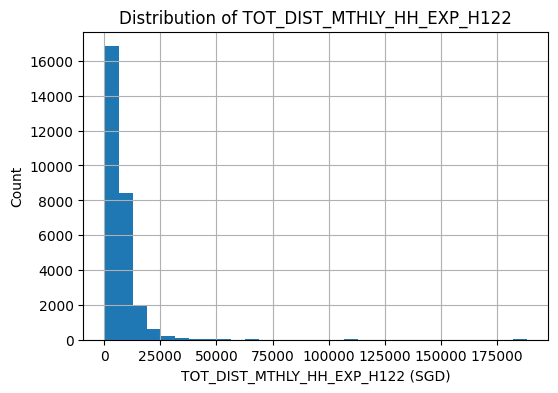

In [21]:
# 2.2 HH_TINC_RCPF_GTRF_E_NAV: total household receipts including grants (net)
plt.figure(figsize=(6,4))
hes_df['TOT_DIST_MTHLY_HH_EXP_H122'].hist(bins=30)
plt.title('Distribution of TOT_DIST_MTHLY_HH_EXP_H122')
plt.xlabel('TOT_DIST_MTHLY_HH_EXP_H122 (SGD)')
plt.ylabel('Count')
plt.show()

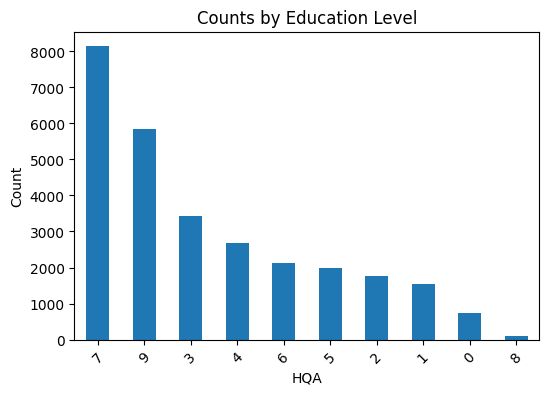

In [22]:
# 2.3 Education level frequencies
# HQA: highest education level attained
edu_counts = hes_df['HQA'].value_counts()
plt.figure(figsize=(6,4))
edu_counts.plot(kind='bar')
plt.title('Counts by Education Level')
plt.xlabel('HQA')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


# Groups for reference: 

# 0	No Formal Education/Pre-Primary/Lower Primary
# 1	Primary
# 2	Lower Secondary
# 3	Secondary
# 4	Post-Secondary (Non-Tertiary), With at least 1 GCE ‘A’ Level Pass, ITE Certificate in Office Skills, ITE Certificate in Business Studies, NTC Grade 1, NTC Grade 2, ITC, Nitec/Higher Nitec/Master Nitec or Equivalent
# 5	Polytechnic Diploma 
# 6	Professional Qualification and Other Diploma (e.g. ITE Diploma, ACCA, CFA, SIM Diploma, NIE Diploma)
# 7	Bachelor's Degree or Equivalent or Postgraduate diploma/certificate (excluding Master's and Doctorate) (e.g NIE post-graduate diploma) or Master's and Doctorate or equivalent
# 8	Others (e.g. Modular certifications (non-award courses/Non-full qualifications)
# 9	Full-time student/schooling or persons aged below 10 years or maids



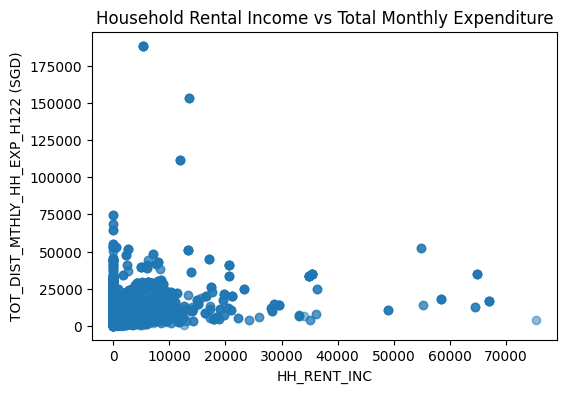

In [23]:
# 2.4 Relationship of household rental income to total expenditure
# Plot scatter of household rental income vs DV to assess linear trend
plt.figure(figsize=(6,4))
plt.scatter(hes_df['HH_RENT_INC'], hes_df['TOT_DIST_MTHLY_HH_EXP_H122'], alpha=0.5)
plt.title('Household Rental Income vs Total Monthly Expenditure')
plt.xlabel('HH_RENT_INC')
plt.ylabel('TOT_DIST_MTHLY_HH_EXP_H122 (SGD)')
plt.show()

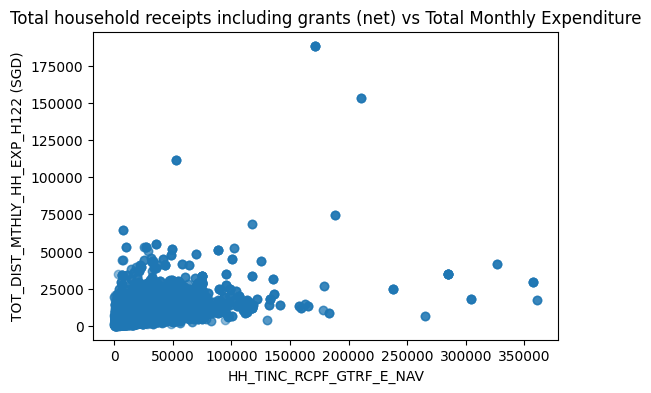

In [24]:
# 2.5 Household receipts vs expenditure
plt.figure(figsize=(6,4))
plt.scatter(hes_df['HH_TINC_RCPF_GTRF_E_NAV'], hes_df['TOT_DIST_MTHLY_HH_EXP_H122'], alpha=0.5)
plt.title('Total household receipts including grants (net) vs Total Monthly Expenditure')
plt.xlabel('HH_TINC_RCPF_GTRF_E_NAV')
plt.ylabel('TOT_DIST_MTHLY_HH_EXP_H122 (SGD)')
plt.show()

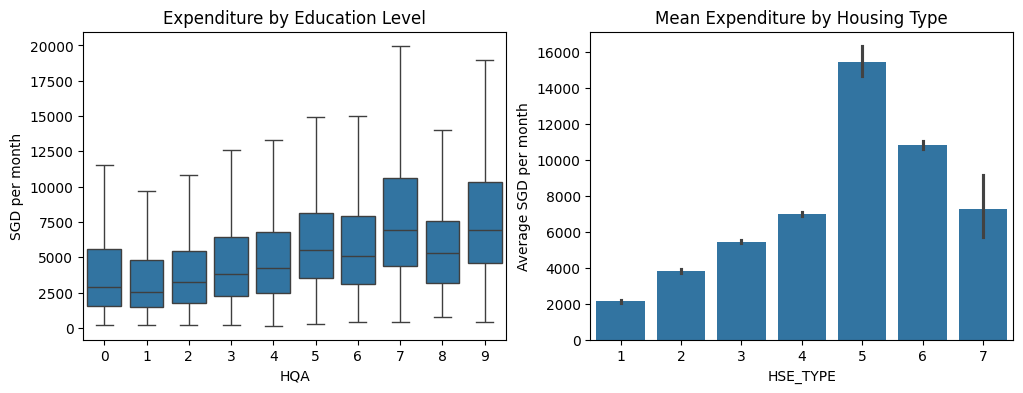

In [25]:
# 2.6 Categorical predictors: education and housing type
# HQA: education level | HSE_TYPE: housing type
import seaborn as sns

fig, axes = plt.subplots(1,2, figsize=(12,4))

# Boxplot DV by education with seaborn
sns.boxplot(data=hes_df, x='HQA', y='TOT_DIST_MTHLY_HH_EXP_H122', 
            ax=axes[0], showfliers=False)
axes[0].set_title('Expenditure by Education Level')
axes[0].set_xlabel('HQA')
axes[0].set_ylabel('SGD per month')
axes[0].tick_params(axis='x')  # Rotate labels if needed

# Bar chart mean DV by housing type
sns.barplot(data=hes_df, x='HSE_TYPE', y='TOT_DIST_MTHLY_HH_EXP_H122', 
            ax=axes[1], estimator='mean')
axes[1].set_title('Mean Expenditure by Housing Type')
axes[1].set_xlabel('HSE_TYPE')
axes[1].set_ylabel('Average SGD per month')
axes[1].tick_params(axis='x')  

/var/folders/t7/wmm05b497ng5d73yp2y2x_xr0000gn/T/ipykernel_72842/1045133782.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=hes_df, x='HH_YNGCH', y='TOT_DIST_MTHLY_HH_EXP_H122',


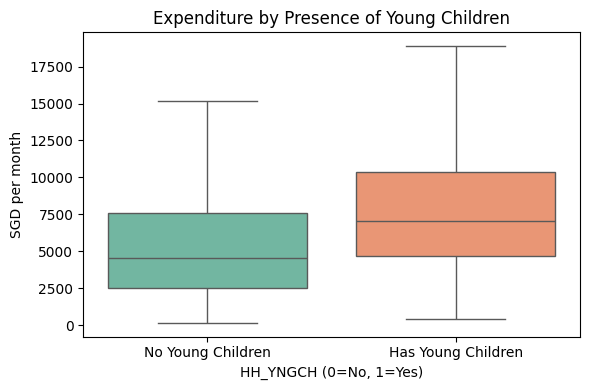

In [26]:
# 2.7 Impact of children on expenditure
# HH_YNGCH: indicator for young children (0=No,1=Yes)
plt.figure(figsize=(6,4))
sns.boxplot(data=hes_df, x='HH_YNGCH', y='TOT_DIST_MTHLY_HH_EXP_H122', 
            showfliers=False, palette='Set2')
plt.title('Expenditure by Presence of Young Children')
plt.xlabel('HH_YNGCH (0=No, 1=Yes)')
plt.ylabel('SGD per month')

# Optional: Make x-axis labels more readable
plt.xticks([0, 1], ['No Young Children', 'Has Young Children'])

plt.tight_layout()
plt.show()

In [27]:
import warnings
warnings.simplefilter(action='ignore')

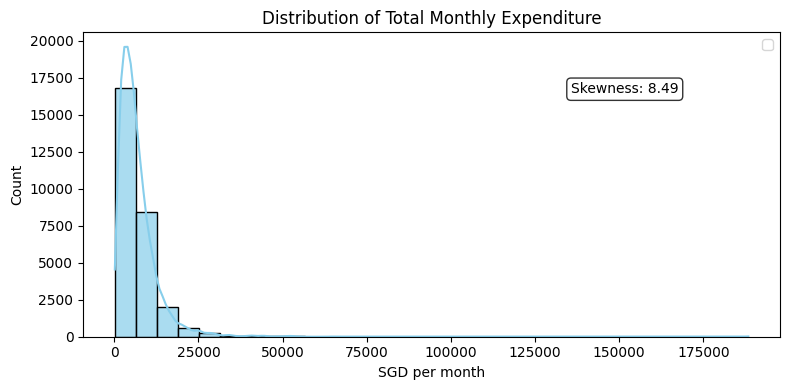

In [28]:
# 2.7 Distribution of the dependent variable
# Check skewness and outliers
plt.figure(figsize=(8,4))

# Use seaborn for better styling
sns.histplot(data=hes_df, x='TOT_DIST_MTHLY_HH_EXP_H122', bins=30, 
             kde=True, color='skyblue', alpha=0.7)
plt.title('Distribution of Total Monthly Expenditure')
plt.xlabel('SGD per month')
plt.ylabel('Count')

# Add summary statistics as text
skewness = hes_df['TOT_DIST_MTHLY_HH_EXP_H122'].skew()

plt.text(0.7, 0.8, f'Skewness: {skewness:.2f}', transform=plt.gca().transAxes, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.legend()
plt.tight_layout()
plt.show()

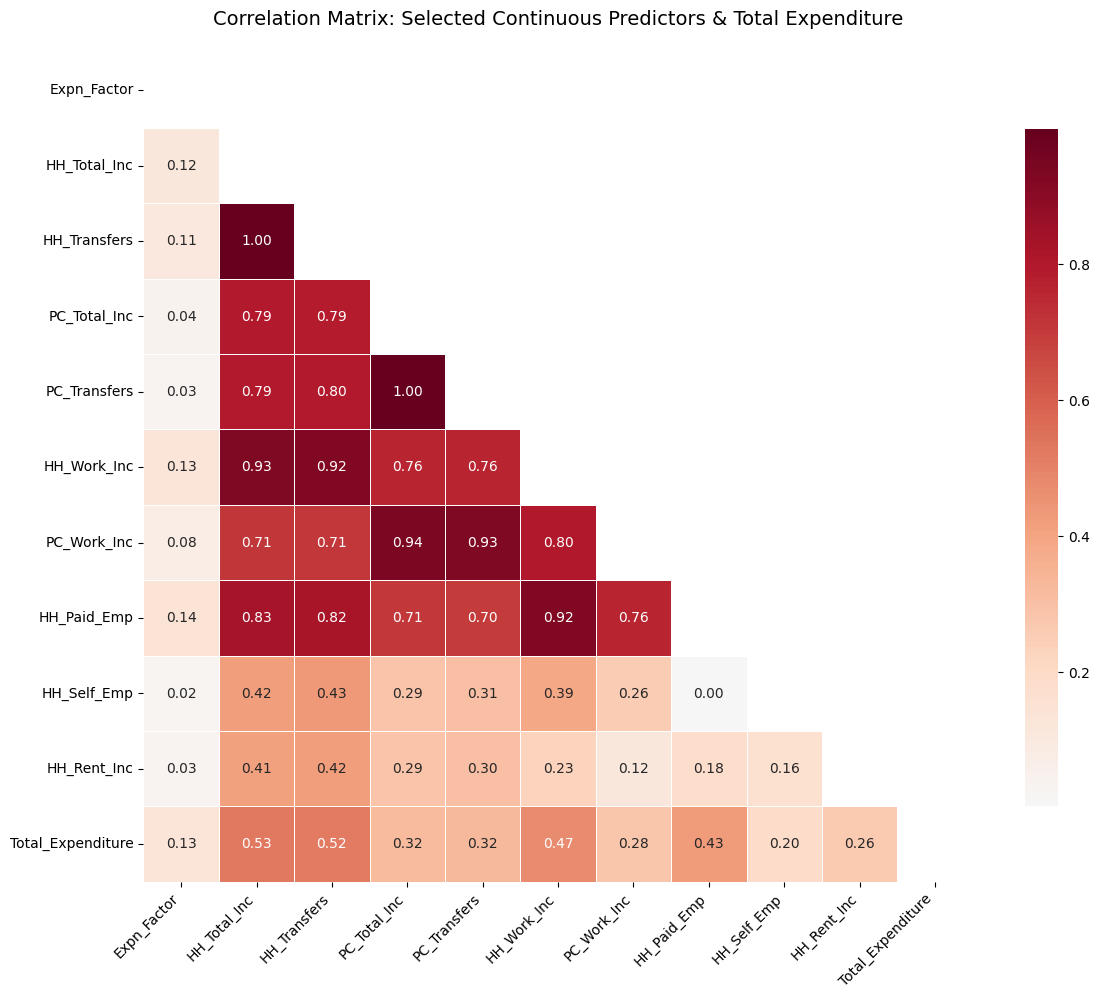


Correlations with Total Expenditure:
HH_Total_Inc        : 0.526
HH_Transfers        : 0.522
HH_Work_Inc         : 0.472
HH_Paid_Emp         : 0.430
PC_Transfers        : 0.323
PC_Total_Inc        : 0.320
PC_Work_Inc         : 0.279
HH_Rent_Inc         : 0.264
HH_Self_Emp         : 0.196
Expn_Factor         : 0.128


In [29]:
# 2.8 Correlation matrix among selected continuous predictors and the DV
import seaborn as sns
import numpy as np

# Define the 10 continuous predictors of interest with shorter labels
cont_vars = [
    'EXPN_FAC',                   # Expenditure factor
    'HH_TINC_RCPF_GTRF_E_NAV',    # Total household receipts incl. grants (net)
    'HH_TINC_GTRF_E_NAV',         # Total household transfers (net)
    'PC_HH_TINC_RCPF_GTRF_E_NAV', # Per-capita household receipts incl. grants
    'PC_HH_TINC_GTRF_E_NAV',      # Per-capita household transfers
    'HH_WRK_INC_RCPF',            # Household earned income receipts (net)
    'PC_HH_WRK_INC_RCPF',         # Per-capita earned income receipts
    'HH_PAID_EMP_INC_RCPF',       # Household paid employment income receipts
    'HH_SELF_EMP_INC',            # Household self-employment income
    'HH_RENT_INC'                 # Household rental income
]

# Create shorter, more readable labels
short_labels = [
    'Expn_Factor', 'HH_Total_Inc', 'HH_Transfers', 'PC_Total_Inc', 'PC_Transfers',
    'HH_Work_Inc', 'PC_Work_Inc', 'HH_Paid_Emp', 'HH_Self_Emp', 'HH_Rent_Inc'
]

# Dependent variable
dv = 'TOT_DIST_MTHLY_HH_EXP_H122'  # Total monthly household expenditure (SGD)

# Build correlation matrix
vars_corr = cont_vars + [dv]
corr = hes_df[vars_corr].corr()

# Rename columns and index for better readability
labels_dict = dict(zip(cont_vars, short_labels))
labels_dict[dv] = 'Total_Expenditure'
corr = corr.rename(index=labels_dict, columns=labels_dict)

# Create mask for upper triangle (optional - removes redundancy)
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr,
    mask=mask,           # Hide upper triangle
    annot=True,
    fmt='.2f',
    cmap='RdBu_r',       # Red-Blue colormap (red=positive, blue=negative)
    center=0,            # Center colormap at 0
    square=True,
    cbar_kws={'shrink': .8},
    linewidths=0.5
)
plt.title('Correlation Matrix: Selected Continuous Predictors & Total Expenditure', 
          fontsize=14, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print correlations with DV specifically
print("\nCorrelations with Total Expenditure:")
dv_corrs = corr['Total_Expenditure'].sort_values(ascending=False)
for var, corr_val in dv_corrs.items():
    if var != 'Total_Expenditure':
        print(f"{var:<20}: {corr_val:.3f}")


## Hypothesis Testing


We’ll test three hypotheses, all with the dependent variable **TOT_DIST_MTHLY_HH_EXP_H122** (total monthly household expenditure, code H122).

### Two-Sample t-Test  
**Question:** Do households **with children** spend a different amount on average than those **without children**?

In [33]:
from scipy.stats import ttest_ind

# Create a flag for “has children”:
# RELT_TO_HD codes 5 = Son/Daughter, 9 = Grandchild
child_codes = [5, 9]
# Identify households (HREF_NO) that have at least one child
child_households = hes_df[hes_df['RELT_TO_HD'].isin(child_codes)]['HREF_NO'].unique()
# Boolean flag in hes_df
hes_df['has_children'] = hes_df['HREF_NO'].isin(child_households)

# Split the groups
exp_with = hes_df.loc[hes_df['has_children'], 'TOT_DIST_MTHLY_HH_EXP_H122']
exp_without = hes_df.loc[~hes_df['has_children'], 'TOT_DIST_MTHLY_HH_EXP_H122']

# Perform Welch’s t-test 
t_stat, p_val = ttest_ind(exp_with, exp_without, equal_var=False)

print(f"T-statistic: {t_stat:.3f}")
print(f"P-value:      {p_val:.3f}")



T-statistic: 54.540
P-value:      0.000


In [108]:
t_stat

54.53992244983232

- The t-statistic measures standardized difference in means between two groups.
- p-value = probability of observing that difference (or more extreme) if the true means are equal.

- If p < 0.05, reject H₀: conclude the groups differ significantly.
- Report direction: compare group means to say “households with children spend more than those without” if mean₁ > mean₂.

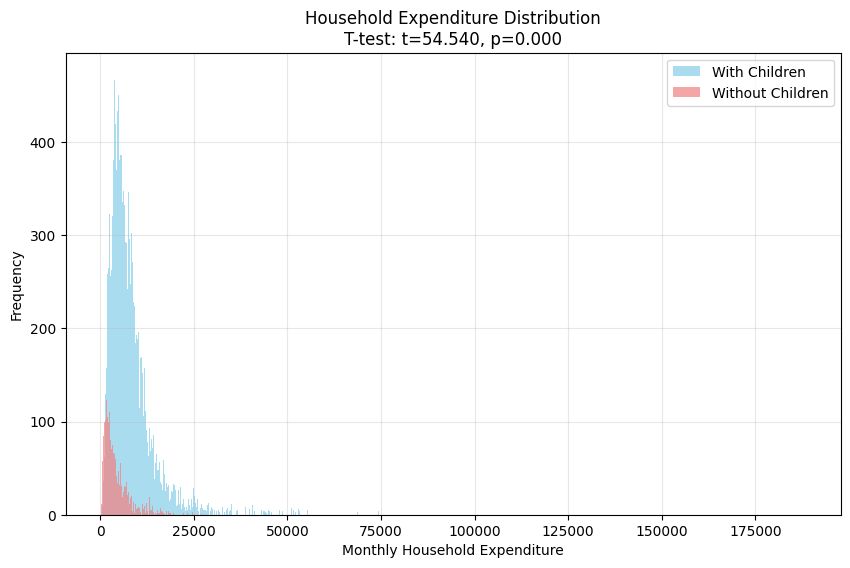

In [110]:
# histogram comparison
plt.figure(figsize=(10, 6))
plt.hist(exp_with.dropna(), bins=1000, alpha=0.7, label='With Children', color='skyblue')
plt.hist(exp_without.dropna(), bins=1000, alpha=0.7, label='Without Children', color='lightcoral')

plt.xlabel('Monthly Household Expenditure')
plt.ylabel('Frequency')
plt.title(f'Household Expenditure Distribution\nT-test: t={t_stat:.3f}, p={p_val:.3f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

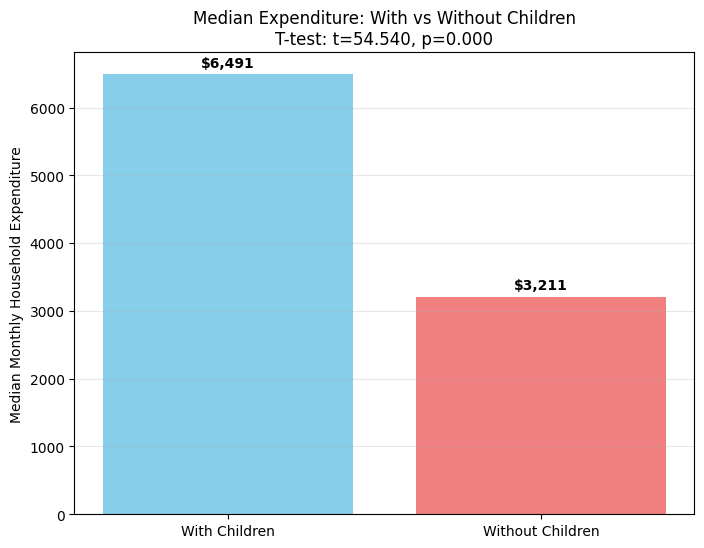

In [112]:
# Bar graph: With/Without Children
plt.figure(figsize=(8, 6))
categories = ['With Children', 'Without Children']
medians = [exp_with.median(), exp_without.median()]

plt.bar(categories, medians, color=['skyblue', 'lightcoral'])
plt.ylabel('Median Monthly Household Expenditure')
plt.title(f'Median Expenditure: With vs Without Children\nT-test: t={t_stat:.3f}, p={p_val:.3f}')
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, median in enumerate(medians):
    plt.text(i, median + max(medians)*0.01, f'${median:,.0f}', 
             ha='center', va='bottom', fontweight='bold')

plt.show()

#### General Reporting Tips

- State your hypotheses (H₀ and H₁) clearly.
- Report test statistic, degrees of freedom, and p-value (e.g., t(48)=2.13, p=0.038).
- Interpret in context: “With p=0.038, we conclude that mean monthly expenditure differs between groups.”

### ANOVA
**Question**: Does education level (LVL_OF_EDN) affect total expenditure?

To test for differences in the mean of a continuous variable across more than two groups, we can use analysis of variance (ANOVA).
In short, ANOVA is used to compare multiple groups! 


In [114]:
from scipy.stats import f_oneway

# Prepare groups by education level
groups = []
for lvl in sorted(hes_df['HQA'].unique()):
    grp = hes_df.loc[hes_df['HQA'] == lvl, 'TOT_DIST_MTHLY_HH_EXP_H122']
    groups.append(grp.dropna())

# Run ANOVA
f_stat, p_val_anova = f_oneway(*groups)

print(f"F-statistic: {f_stat:.3f}")
print(f"P-value:     {p_val_anova:.10f}")

F-statistic: 233.005
P-value:     0.0000000000


- The F-statistic is the ratio of “between-group variance” to “within-group variance.”
- p-value = probability of observing that F if all group means are equal.
- If p < 0.05, reject H₀: at least one group mean differs.
- You may follow with post-hoc tests (e.g. t-test) to pinpoint which pairs differ.

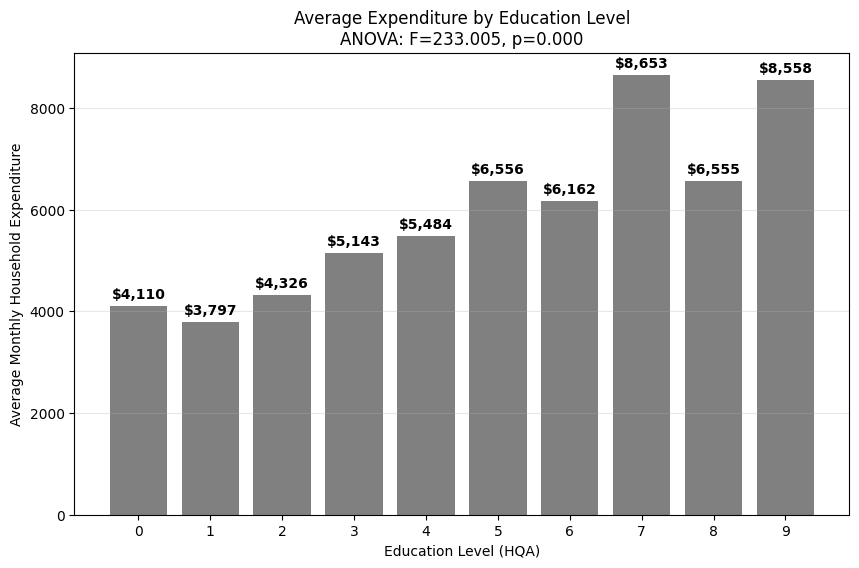

In [116]:
# Bar graph 2: Education levels
plt.figure(figsize=(10, 6))
education_levels = sorted(hes_df['HQA'].unique())
education_means = [grp.mean() for grp in groups]

plt.bar(range(len(education_levels)), education_means, color='grey')
plt.xlabel('Education Level (HQA)')
plt.ylabel('Average Monthly Household Expenditure')
plt.title(f'Average Expenditure by Education Level\nANOVA: F={f_stat:.3f}, p={p_val_anova:.3f}')
plt.xticks(range(len(education_levels)), education_levels)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, mean in enumerate(education_means):
    plt.text(i, mean + max(education_means)*0.01, f'${mean:,.0f}', 
             ha='center', va='bottom', fontweight='bold')

plt.show()

### Chi-square test
When we have two categorical variables and want to see if their statuses are associated, we can use the chi-square test. 

Question: Is there an association between car ownership (_DRBLE12: number of cars) and tenancy (TENANCY: 1=owner, 2=renter)?


In [43]:
# Flag households that own at least one car
# (_DRBLE12 is “Number of Car” from CEI metadata)
hes_df['has_car'] = hes_df['_DRBLE12'].fillna(0) > 0

# Build contingency table: car ownership vs tenancy status
ct = pd.crosstab(hes_df['has_car'], hes_df['TENANCY'])

print("Contingency Table:")
print(ct)

Contingency Table:
TENANCY      1     2
has_car             
False    14414  1923
True     11351   646


We use the `chi2_contingency()` function to run the chi-square test, and assign the results to a variable. This shows that we can reject the null hypothesis that the two are independent. The results are returned as a tuple.

In [118]:
from scipy.stats import chi2_contingency

# Perform Chi-Square test
chi2, p, dof, expected = chi2_contingency(ct)

print(f"\nChi2 statistic: {chi2:.3f}")
print(f"P-value:        {p:.10f}")



Chi2 statistic: 341.392
P-value:        0.0000000000



- The chi-square test you ran is assessing whether car ownership ("Has Car" vs. "No Car") is independent of tenancy status. Here's how to interpret the numbers:
- χ² = 341.392
- This is the test statistic, which measures how much the observed counts in each car ownership × tenancy cell deviate from the counts you would expect if there were no association (i.e. if car ownership and tenancy status were truly independent). This is a very large chi-square value, indicating substantial deviation from independence.
- p-value = 0.000: This is the probability of observing a χ² as large as 341.392 (or larger) if the null hypothesis of independence were true. A p-value of essentially 0.000 is far below any common significance threshold (e.g. 0.05), so we strongly reject the null hypothesis.
- Conclusion: There is extremely strong statistical evidence that car ownership and tenancy status are not independent - they are significantly associated with each other. The relationship between these variables is highly statistically significant.

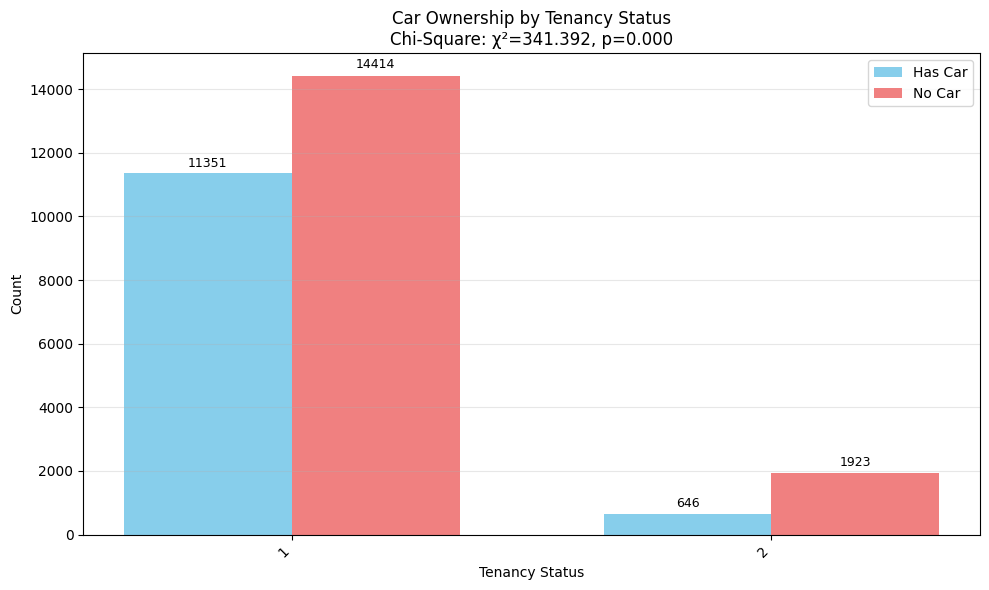

In [120]:
# Bar graph 1: Grouped bar chart from contingency table
plt.figure(figsize=(10, 6))

# Prepare data for plotting
tenancy_categories = ct.columns.tolist()
has_car_counts = ct.loc[True].values if True in ct.index else [0] * len(tenancy_categories)
no_car_counts = ct.loc[False].values if False in ct.index else [0] * len(tenancy_categories)

x = np.arange(len(tenancy_categories))
width = 0.35

# Create grouped bars
bars1 = plt.bar(x - width/2, has_car_counts, width, label='Has Car', color='skyblue')
bars2 = plt.bar(x + width/2, no_car_counts, width, label='No Car', color='lightcoral')

plt.xlabel('Tenancy Status')
plt.ylabel('Count')
plt.title(f'Car Ownership by Tenancy Status\nChi-Square: χ²={chi2:.3f}, p={p:.3f}')
plt.xticks(x, tenancy_categories, rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    if height > 0:
        plt.text(bar.get_x() + bar.get_width()/2., height + max(has_car_counts)*0.01,
                f'{int(height)}', ha='center', va='bottom', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    if height > 0:
        plt.text(bar.get_x() + bar.get_width()/2., height + max(no_car_counts)*0.01,
                f'{int(height)}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

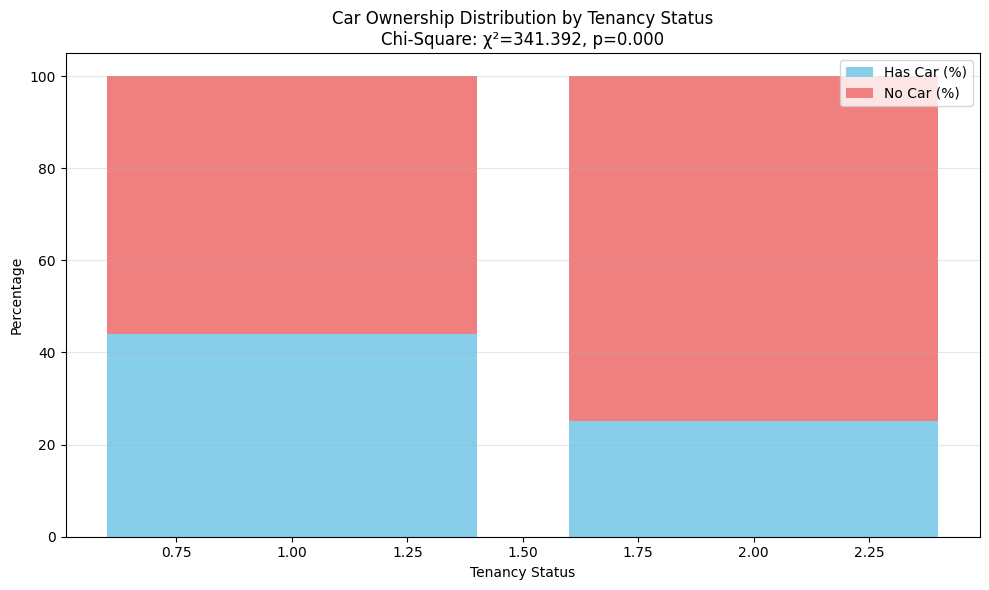

In [48]:
# Bar graph 2: Stacked bar chart showing proportions
plt.figure(figsize=(10, 6))

# Calculate proportions
total_by_tenancy = ct.sum(axis=0)
prop_has_car = (ct.loc[True] / total_by_tenancy * 100) if True in ct.index else pd.Series([0] * len(tenancy_categories), index=tenancy_categories)
prop_no_car = (ct.loc[False] / total_by_tenancy * 100) if False in ct.index else pd.Series([0] * len(tenancy_categories), index=tenancy_categories)

plt.bar(tenancy_categories, prop_has_car, label='Has Car (%)', color='skyblue')
plt.bar(tenancy_categories, prop_no_car, bottom=prop_has_car, label='No Car (%)', color='lightcoral')

plt.xlabel('Tenancy Status')
plt.ylabel('Percentage')
plt.title(f'Car Ownership Distribution by Tenancy Status\nChi-Square: χ²={chi2:.3f}, p={p:.3f}')
plt.xticks(rotation=0)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Data Transformations for Normality

When working with large survey datasets, variables often span very different ranges and exhibit skewed distributions. In OLS regression, predictors (and sometimes the outcome) that deviate substantially from normality can violate model assumptions—leading to biased estimates, heteroscedasticity, and poor inference. To address this, we apply mathematical transformations that:

- **Rescale** extreme values and compress long tails  
- **Symmetrize** skewed distributions  

The most common issue is **skewness**, where one tail of the distribution drags out far from the bulk of observations:  
- **Positive (right) skew**: a long right tail—few large values pull the mean above the median.  
- **Negative (left) skew**: a long left tail—few small values pull the mean below the median.  



In [122]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

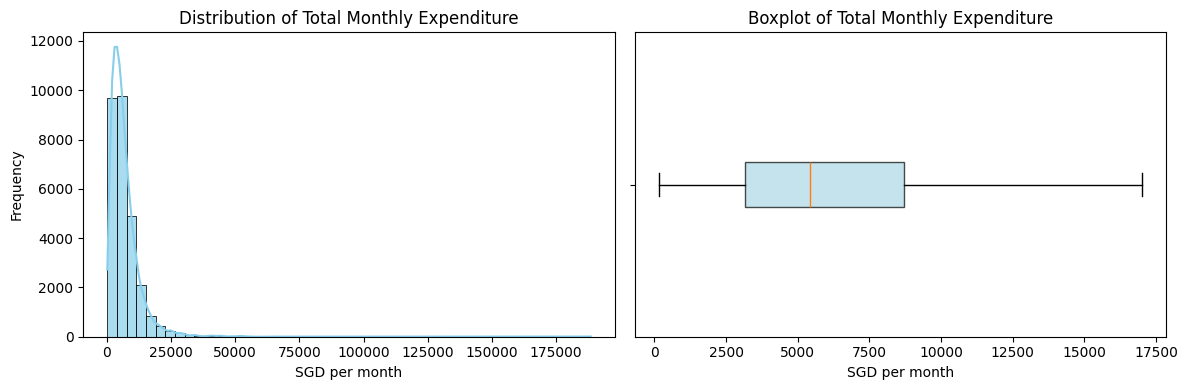


Skewness: 8.488
Note: This variable is right‐skewed (long tail to the right), suggesting a log‐transform may help normalize it.


In [124]:
# Univariate: Histogram + Boxplot side-by-side for a skewed variable
import matplotlib.pyplot as plt
import seaborn as sns

skew_var = 'TOT_DIST_MTHLY_HH_EXP_H122'  # highly right‐skewed total monthly expenditure

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram with seaborn styling
sns.histplot(data=hes_df, x=skew_var, bins=50, kde=True, 
             color='skyblue', alpha=0.7, ax=axes[0])
axes[0].set_title('Distribution of Total Monthly Expenditure')
axes[0].set_xlabel('SGD per month')
axes[0].set_ylabel('Frequency')

# Boxplot (horizontal, no outliers)
axes[1].boxplot(hes_df[skew_var], vert=False, showfliers=False, 
                patch_artist=True, boxprops=dict(facecolor='lightblue', alpha=0.7))
axes[1].set_title('Boxplot of Total Monthly Expenditure')
axes[1].set_xlabel('SGD per month')
axes[1].set_yticklabels([])  # Remove y-axis labels for cleaner look

plt.tight_layout()
plt.show()

# Calculate and display skewness
skewness = hes_df[skew_var].skew()
print(f"\nSkewness: {skewness:.3f}")
print("Note: This variable is right‐skewed (long tail to the right), suggesting a log‐transform may help normalize it.")


To correct for skewness and stabilize variances, you can apply several common transforms using NumPy (or SciPy for more advanced options):

- `np.sqrt()` – square‐root transform (good for moderate positive skew and counts)  
- `np.log1p()` – log‐transform with natural log applied to (x + 1), handling zeros gracefully  
- `np.log2()` – log‐transform with base 2  
- `np.log10()` – log‐transform with base 10  
- `scipy.stats.yeojohnson()` – Yeo–Johnson power transform (handles zeros and negatives)  

Each function returns a NumPy array (which you can wrap as a pandas Series). To keep the original data intact, simply assign the transformed values to new columns. For example, if your skewed variable is `TOT_DIST_MTHLY_HH_EXP_H122`, you might do:


In [126]:
import numpy as np
from scipy import stats

# Original skewed variable
var = 'TOT_DIST_MTHLY_HH_EXP_H122'

# One‐line transforms
hes_df[f'sqrt_{var}']    = np.sqrt(hes_df[var])                                           # square‐root
hes_df[f'log1p_{var}']   = np.log1p(hes_df[var])                                         # natural log of (x+1)
hes_df[f'log10_{var}']   = np.log10(hes_df[var].replace(0, np.nan))                       # base‐10 log
hes_df[f'yj_{var}'], _   = stats.yeojohnson(hes_df[var].fillna(0))                        # Yeo–Johnson transform



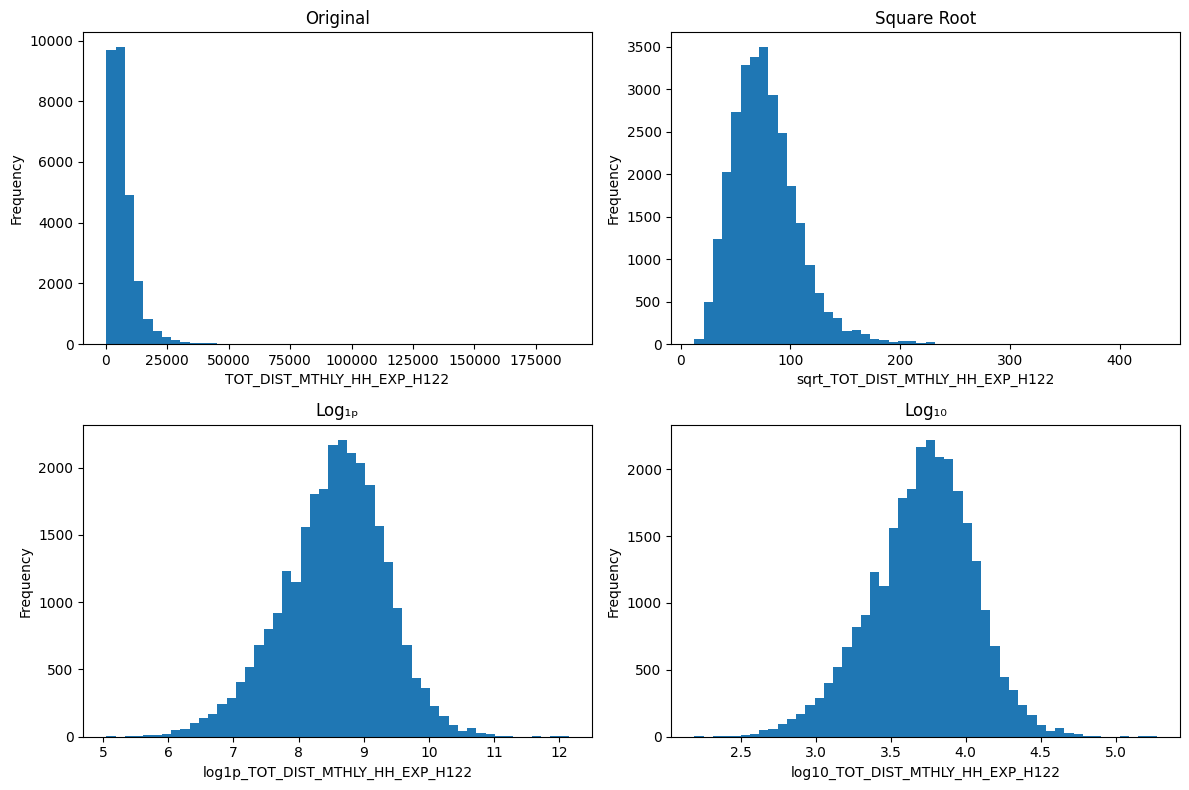

In [128]:
# Define the variable and its transformed versions
var    = 'TOT_DIST_MTHLY_HH_EXP_H122'
cols   = [
    var,
    f'sqrt_{var}',
    f'log1p_{var}',
    f'log10_{var}'
]
titles = ['Original', 'Square Root', 'Log₁ₚ', 'Log₁₀']

# 3. Plot histograms side-by-side
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for ax, col, title in zip(axes.ravel(), cols, titles):
    ax.hist(hes_df[col].dropna(), bins=50)
    ax.set_title(title)
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()



## OLS linear regression (bivariate)
When we have two continuous variables and want to quantify their relationship, we can use **simple linear regression**. In this framework:

- The variable we’re trying to predict is the **response** (our dependent variable).  
- The variable we use to predict it is the **predictor** (our independent variable).  

Simple regression fits a straight line that minimizes the sum of squared distances from each data point to the line.

**Example:** Predict **total monthly household expenditure** (`TOT_DIST_MTHLY_HH_EXP_H122`) from **per-capita household receipts including grants (net)** (`PC_HH_TINC_RCPF_GTRF_E_NAV`), since we expect expenditure to increase as household resources rise.  


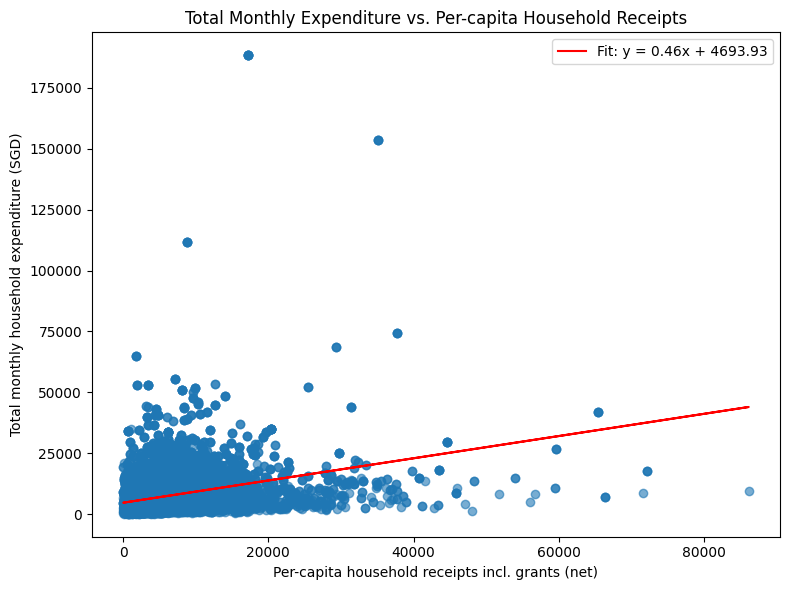

In [130]:
import numpy as np
import matplotlib.pyplot as plt

# Define x (predictor) and y (response)
x = hes_df['PC_HH_TINC_RCPF_GTRF_E_NAV']
y = hes_df['TOT_DIST_MTHLY_HH_EXP_H122']

# Fit a simple linear regression line
slope, intercept = np.polyfit(x, y, 1)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.6)
plt.plot(x, slope * x + intercept, color='red',
         label=f'Fit: y = {slope:.2f}x + {intercept:.2f}')
plt.title('Total Monthly Expenditure vs. Per-capita Household Receipts')
plt.xlabel('Per-capita household receipts incl. grants (net)')
plt.ylabel('Total monthly household expenditure (SGD)')
plt.legend()
plt.tight_layout()
plt.show()


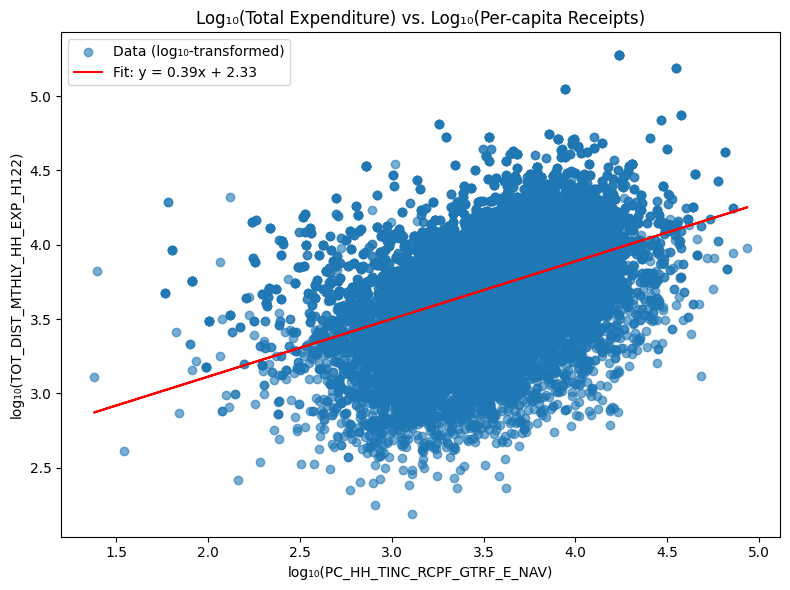

In [132]:
import numpy as np
import matplotlib.pyplot as plt

# Raw predictor and response
x_raw = hes_df['PC_HH_TINC_RCPF_GTRF_E_NAV']
y_raw = hes_df['TOT_DIST_MTHLY_HH_EXP_H122']

# Filter to positive values for log transform
mask = (x_raw > 0) & (y_raw > 0)
x_pos = x_raw[mask]
y_pos = y_raw[mask]

# Log₁₀ transform
x_log10 = np.log10(x_pos)
y_log10 = np.log10(y_pos)

# Fit a simple linear regression line on log-transformed values
slope, intercept = np.polyfit(x_log10, y_log10, 1)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(x_log10, y_log10, alpha=0.6, label='Data (log₁₀-transformed)')
plt.plot(
    x_log10,
    slope * x_log10 + intercept,
    color='red',
    label=f'Fit: y = {slope:.2f}x + {intercept:.2f}'
)
plt.title('Log₁₀(Total Expenditure) vs. Log₁₀(Per-capita Receipts)')
plt.xlabel('log₁₀(PC_HH_TINC_RCPF_GTRF_E_NAV)')
plt.ylabel('log₁₀(TOT_DIST_MTHLY_HH_EXP_H122)')
plt.legend()
plt.tight_layout()
plt.show()



In Python, we can run simple linear regression using the `ols` function from the `statsmodels` package. There are three steps to completing this analysis:
1. **Instantiate** the model: create an object that holds the model specification and the input dataset. In the model specification, the response is to the left of the tilda `~` and the predictor is to the right
2. **Fit** the model: fit the specified model to the data using the `fit()` function, and assign the results object to a variable
3. **Display** the results: use the `summary()` method of the results object to return a detailed breakdown of the model characteristics

In [136]:
df.columns.tolist()

['RELT_TO_HD',
 'AGE',
 'MARITAL_ST',
 'ACTIVITY_ST',
 'HQA',
 'LVL_OF_EDN',
 'SSOC_1D',
 'ID_TYPE',
 'TENANCY',
 'HSE_TYPE',
 'NUM_MAID',
 'EMPLOYMENT_ST',
 'HREF_NO',
 'PI_NO',
 'SP_PI_NO',
 'MO_PI_NO',
 'FA_PI_NO',
 'EXPN_FAC',
 'SEX',
 'MIE_EXC_NAV_IND',
 'HSZ',
 'NUM_WRK_PERS_INC_STUD',
 'RETIREE60_HH',
 'RETIREE65_HH',
 'HLA',
 'HH_YNGCH',
 '_DRBLE01',
 '_DRBLE12',
 '_DRBLE13',
 '_DRBLE16',
 '_DRBLE34',
 '_DRBLE19',
 '_DRBLE20',
 '_DRBLE35',
 '_DRBLE26_27_28',
 '_DRBLE40',
 '_DRBLE06',
 '_DRBLE39',
 '_DRBLE07',
 '_DRBLE08',
 '_DRBLE09',
 '_DRBLE10_41',
 '_DRBLE29_41',
 '_DRBLE41',
 '_DRBLE11',
 '_DRBLE38',
 '_DRBLE15',
 '_DRBLE21',
 '_DRBLE32',
 '_DRBLE36',
 '_DRBLE37',
 'HH_TINC_RCPF_GTRF_E_NAV',
 'HH_TINC_GTRF_E_NAV',
 'PC_HH_TINC_RCPF_GTRF_E_NAV',
 'PC_HH_TINC_GTRF_E_NAV',
 'HH_WRK_INC_RCPF',
 'PC_HH_WRK_INC_RCPF',
 'HH_PAID_EMP_INC_RCPF',
 'HH_SELF_EMP_INC',
 'HH_RENT_INC',
 'HH_INVEST_INC',
 'HH_GOVT_INC',
 'HH_TRANSFER_INC',
 'HH_CONTRIBUTIONS_INC',
 'HH_OTH_TRF_INC',
 'MS_

In [144]:
from statsmodels.formula.api import ols
import numpy as np

# 1. Make log₁₀ transforms of predictor and response
df = hes_df.copy()
df['log10_EXPEND']   = np.log10(df['TOT_DIST_MTHLY_HH_EXP_H122'])
df['log10_RECEIPTS'] = np.log10(df['PC_HH_TINC_RCPF_GTRF_E_NAV'])

# 2. Instantiate the OLS model with transformed variables
simple_model = ols('TOT_DIST_MTHLY_HH_EXP_H122 ~ _DRBLE12', data=df)

# 3. Fit and summarize
simple_results = simple_model.fit()
print(simple_results.summary())


                                OLS Regression Results                                
Dep. Variable:     TOT_DIST_MTHLY_HH_EXP_H122   R-squared:                       0.338
Model:                                    OLS   Adj. R-squared:                  0.338
Method:                         Least Squares   F-statistic:                 1.447e+04
Date:                        Tue, 15 Jul 2025   Prob (F-statistic):               0.00
Time:                                15:54:44   Log-Likelihood:            -2.8447e+05
No. Observations:                       28334   AIC:                         5.689e+05
Df Residuals:                           28332   BIC:                         5.690e+05
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

The model summary contains a lot of detailed information, but we can create a more concise report of the results by extracting the results of interest e.g. the r2 value, the F-statistic and its p value:

In [146]:
# 4. Extract and print key metrics
print("Simple linear regression:")
print(f"R²               = {simple_results.rsquared:.3f}")
print(f"F-statistic      = {simple_results.fvalue:.3f}")
print(f"F-statistic p-value = {simple_results.f_pvalue:.3e}")

Simple linear regression:
R²               = 0.338
F-statistic      = 14466.810
F-statistic p-value = 0.000e+00


Here’s how to read those key numbers:

- **R² = 0.175**  
  About 17.5 % of the variation in log₁₀(total monthly expenditure) is explained by log₁₀(per-capita receipts) alone. That’s a modest but meaningful single-predictor relationship for real-world household spending data.

- **F-statistic = 6027 (p < 0.001)**  
  Tests the null hypothesis that an intercept-only model fits as well as one including log₁₀(per-capita receipts). Such an extremely large F-statistic and vanishing p-value tell us the predictor adds highly significant explanatory power.

- **Intercept ≈ 2.335 (p < 0.001)**  
  When log₁₀(per-capita receipts) = 0 (i.e., receipts = 1 SGD), hypothetical value of log expenditure.
  (Often not directly meaningful if 1 SGD is outside the data range, but it anchors the regression line.)

- **Slope ≈ 0.3885 (p < 0.001)**  
  A one-unit increase in log₁₀(per-capita receipts)—equivalent to a tenfold increase in receipts—is associated with a 0.3885 increase in log₁₀(expenditure).  
  - Translating back: a tenfold rise in receipts corresponds to about a 2.45× increase in expenditure.  
  - In elasticity terms: roughly a 0.39 % increase in expenditure for each 1 % increase in receipts.


### Another example - with prediction

In [64]:
# Dependent variable: TRANSPORT (_07) – monthly transport expenditure (SGD)
# Predictor: PC_HH_WRK_INC_RCPF – per-capita earned income receipts (net, SGD)


In [148]:
import statsmodels.api as sm

# Define predictor and response
X = sm.add_constant(hes_df['_DRBLE12'])       
y = hes_df['TOT_DIST_MTHLY_HH_EXP_H122']                   

# Fit the model
model = sm.OLS(y, X).fit()
print(model.summary())


                                OLS Regression Results                                
Dep. Variable:     TOT_DIST_MTHLY_HH_EXP_H122   R-squared:                       0.338
Model:                                    OLS   Adj. R-squared:                  0.338
Method:                         Least Squares   F-statistic:                 1.447e+04
Date:                        Tue, 15 Jul 2025   Prob (F-statistic):               0.00
Time:                                15:58:53   Log-Likelihood:            -2.8447e+05
No. Observations:                       28334   AIC:                         5.689e+05
Df Residuals:                           28332   BIC:                         5.690e+05
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

**How to read these key numbers:**

- **R² = 0.020**  
  Only 2.0 % of the variation in monthly transport expenditure (_07) is explained by per-capita earned income (PC_HH_WRK_INC_RCPF) alone. This is a very modest fit, suggesting many other factors drive transport spending.

- **F-statistic = 592.8 (p < 1 × 10⁻¹²⁹)**  
  Tests the null hypothesis that an intercept-only model fits as well as one including per-capita income. Such a huge F and vanishing p-value tell us adding income yields a highly significant improvement—despite the low R².

- **Intercept ≈ 741.24 (p < 0.001)**  
  When per-capita earned income = 0 SGD, the model predicts average transport spending of about 741 SGD/month. (Not literally meaningful if zero income is outside the data range, but it anchors the regression line.)

- **Slope ≈ 0.1071 (p < 0.001)**  
  For each additional 1 SGD of per-capita earned income, transport expenditure increases by roughly 0.11 SGD. This small but statistically significant coefficient indicates higher-earning households spend slightly more on transport.

---

**Diagnostics & Caveats:**

- **Residual non-normality:**  
  The Omnibus and Jarque–Bera tests are highly significant, with extreme skew (≈ 19.6) and kurtosis (≈ 557.7), indicating the residuals are far from Gaussian. Consider transforming the DV or using robust standard errors.



After fitting a linear regression model, we usually want to carry out some basic checks of the model characteristics. This is because linear regression makes some assumptions about the data and our model, and if the data that we have fitted our model to has violated these assumptions, then the predictions from the model may not be reliable. We will not cover these checks in this session as they are beyond the scope of the course, but if you want information on how to do this then please see the [statsmodels documentation](https://www.statsmodels.org/stable/index.html).

If we are happy with the checks of model characteristics, we can use the model to predict what the value of our response variable will be, given a certain value for the predictor variable. We do this using the `predict()` method of the results object, which takes the value of the predictor variable as the argument:

In [150]:
import pandas as pd
import statsmodels.api as sm

# Suppose you want predictions for three households with these per‐capita incomes:
new_vals = pd.DataFrame({'_DRBLE12': [ 0, 1, 10 ]})

# 1) Add the constant term
new_X = sm.add_constant(new_vals)

# 2) Get predictions
preds = model.predict(new_X)

print(preds)



0     3975.745447
1     9916.245264
2    63380.743624
dtype: float64
